In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import altair as alt
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import os

plt.style.use('bmh')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%pwd
%load_ext altair

In [2]:
import sys
sys.path.append('../datasets/')

In [103]:
# Load the data
train_df = pd.read_csv("../datasets/digits_recognizer/train.csv")
test_df = pd.read_csv("../datasets/digits_recognizer/test.csv")
submission = pd.read_csv("../datasets/digits_recognizer/sample_submission.csv")
test_df['label'] = submission['Label']
print(train_df.shape, test_df.shape)

(42000, 785) (28000, 785)


# 1) Prep Data

In [278]:
from sklearn.model_selection import train_test_split

target_col = ['label']
feature_cols = list(train_df.drop(labels=target_col, axis=1).columns)
len(feature_cols)
X_train_prep = (train_df[feature_cols] / 255)
# 1-hot train y labels
y_train_prep = pd.get_dummies(train_df[target_col].label).values.copy()

X_test = (test_df[feature_cols] / 255)
# 1-hot test y labels
y_test = pd.get_dummies(test_df[target_col[0]])

X_train, X_val, y_train, y_val = train_test_split(X_train_prep, y_train_prep, test_size=0.1, random_state=37)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape, X_test.shape, y_test.shape)

(37800, 784) (4200, 784) (37800, 10) (4200, 10) (28000, 784) (28000, 1)


# 2) Basic Run 

## a) Compile, Fit and Evaluate Model

In [279]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [280]:
# Define the model
model = Sequential()
# Input and Hidden Layers
model.add(Dense(units=32, activation='relu', input_shape=(X.shape[0],))) # Input layer for 784 features
model.add(Dropout(0.7))  # 50% neurons deactivated randomly
model.add(Dense(units=32, activation='relu')) # Hidden layers and ReLU activation
model.add(Dropout(0.7))  # 50% neurons deactivated randomly
# Output layer
model.add(Dense(units=10, activation='softmax'))  # 10 units for 10 digits

/Users/rishikeshdole/.pyenv/versions/3.11.1/envs/nn_llm_env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [281]:
# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)  # Stop if no improvement for 3 epochs

# Compile the model
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # Tune the learning rate
model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=64, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_train, y_train)

print(f'Training Accuracy: {accuracy*100:.2f}%')

Epoch 1/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 1s 730us/step - accuracy: 0.2087 - loss: 2.1042 - val_accuracy: 0.7810 - val_loss: 1.0511
Epoch 2/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - accuracy: 0.4416 - loss: 1.5433 - val_accuracy: 0.8502 - val_loss: 0.7731
Epoch 3/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - accuracy: 0.4951 - loss: 1.4149 - val_accuracy: 0.8686 - val_loss: 0.7159
Epoch 4/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - accuracy: 0.5071 - loss: 1.3662 - val_accuracy: 0.8669 - val_loss: 0.6639
Epoch 5/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.5189 - loss: 1.3343 - val_accuracy: 0.8779 - val_loss: 0.6555
Epoch 6/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.5276 - loss: 1.3067 - val_accuracy: 0.8752 - val_loss: 0.6466
Epoch 7/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - accuracy: 0.5346 - loss: 1.3015 - val_accuracy: 0.8867 - val_loss: 0.6070
Epoch 8/50
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.5534 - loss: 1.2639 - 

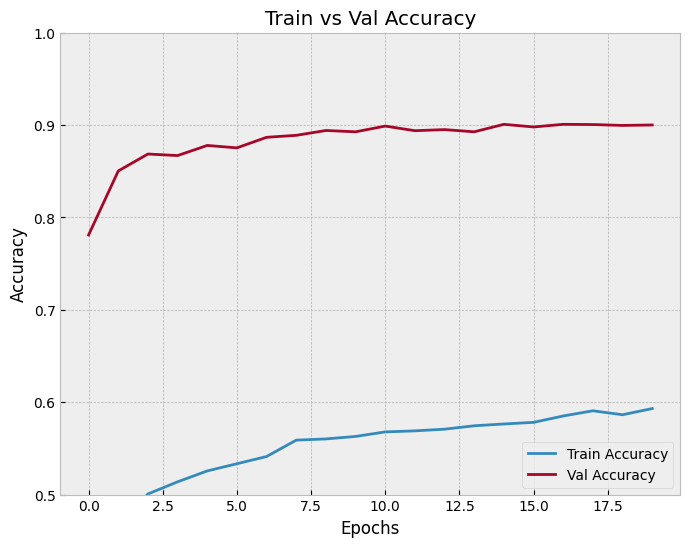

In [282]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.plot(history.history['accuracy'], label='Train Accuracy')
ax.plot(history.history['val_accuracy'], label='Val Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.5, 1);
ax.legend(loc='lower right');
ax.set_title('Train vs Val Accuracy');

## b) Test on test Dataset

In [283]:
y_pred_test = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_test, axis=1)
# Ensure predictions are diverse by checking unique predictions
pd.Series(y_pred_classes).value_counts()

875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 261us/step


8    3574
1    3110
4    3003
6    2834
7    2697
3    2674
2    2646
0    2636
9    2614
5    2212
dtype: int64

In [284]:
final_submission = pd.DataFrame()
final_submission['ImageId'] = submission['ImageId']
final_submission['Label'] = np.argmax(y_pred_test, axis=1)
final_submission.to_csv('../datasets/digits_recognizer/my_submission.csv', sep=',', index=False)

In [ ]:
# basic submission gets a score of 0.81 with the test dataset. let's reduce the learning rate and see, and convert this into function calls:

# 3) Updated Run

In [347]:
import sys
sys.path.append('../src/')
import tf_deep_learning

In [348]:
input_shape = X_train.shape[1]
hidden_layers = [32, 32, 100, 50, 20]
output_units = 10
dropout_rate = 0.2
model = tf_deep_learning.tf_model(input_shape, hidden_layers, output_units, dropout_rate)

In [350]:
epochs = 1000
batch_size=64
learning_rate=0.01
trained_model, history, train_accuracy, val_accuracy = tf_deep_learning.fit_and_evaluate(model, X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate)
train_accuracy, val_accuracy

Epoch 1/1000
591/591 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step - accuracy: 0.9081 - loss: 0.3903 - val_accuracy: 0.9274 - val_loss: 0.3054
Epoch 2/1000
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.9033 - loss: 0.3972 - val_accuracy: 0.9276 - val_loss: 0.2955
Epoch 3/1000
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.9126 - loss: 0.3643 - val_accuracy: 0.9340 - val_loss: 0.3015
Epoch 4/1000
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.9158 - loss: 0.3519 - val_accuracy: 0.9321 - val_loss: 0.3112
Epoch 5/1000
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - accuracy: 0.9131 - loss: 0.3577 - val_accuracy: 0.9260 - val_loss: 0.3240
1182/1182 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - accuracy: 0.9361 - loss: 0.2630
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 323us/step - accuracy: 0.9246 - loss: 0.3362


(0.9360317587852478, 0.9259523749351501)

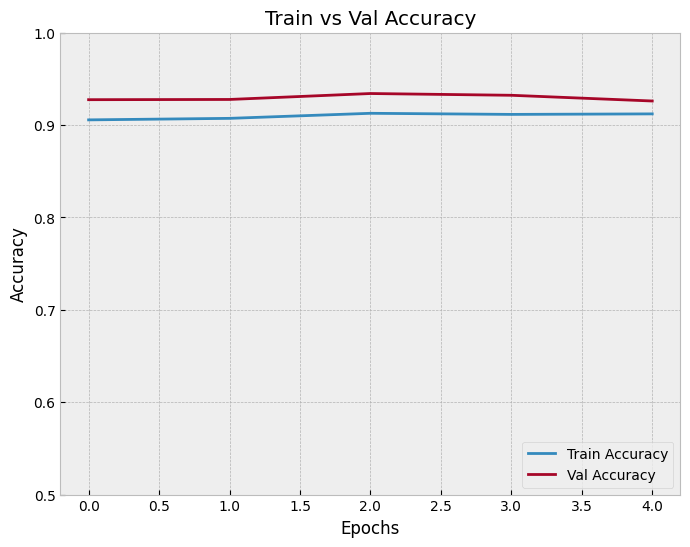

In [351]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.plot(history.history['accuracy'], label='Train Accuracy')
ax.plot(history.history['val_accuracy'], label='Val Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.5, 1);
ax.legend(loc='lower right');
ax.set_title('Train vs Val Accuracy');

In [352]:
y_pred_test = trained_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_test, axis=1)
# Ensure predictions are diverse by checking unique predictions
pd.Series(y_pred_classes).value_counts()

875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 292us/step


2    3140
1    3089
7    2987
9    2839
4    2831
8    2815
6    2707
0    2681
3    2518
5    2393
dtype: int64

In [353]:
final_submission = pd.DataFrame()
final_submission['ImageId'] = submission['ImageId']
final_submission['Label'] = np.argmax(y_pred_test, axis=1)
final_submission.to_csv('../datasets/digits_recognizer/my_submission_2.csv', sep=',', index=False)

#train and val are pretty close, so now we should try to increase the train accuracy. so, now we will try to do some hyperparameter tuning

# 4) HP Run

In [447]:
def build_model(hp):
    input_shape = 784
    output_units = 10
    
    # Define hyperparameters using hp
    num_hidden_layers = hp.Int('num_hidden_layers', 1, 7)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.9, step=0.1)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    
    # Create a list for units in hidden layers
    hidden_layers = [hp.Int(f'units_{i+1}', min_value=40, max_value=256, step=32) for i in range(num_hidden_layers)]

    # Call the model-building function with these hyperparameters
    model = tf_deep_learning.tf_model(input_shape, hidden_layers, output_units, dropout_rate, learning_rate)

    return model

In [448]:
# Initialize the RandomSearch tuner
from kerastuner import RandomSearch
input_shape = X_train.shape[1]
output_units = 10
tuner = RandomSearch(lambda hp: build_model(hp),
                     objective='val_accuracy',
                     max_trials=10,
                     executions_per_trial=1,
                     directory='random_search',
                     project_name='random_search3')

/Users/rishikeshdole/.pyenv/versions/3.11.1/envs/nn_llm_env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [449]:
tuner.search(X_train, y_train,
             epochs=100,
             batch_size=128,
             validation_data=(X_val, y_val))

Trial 10 Complete [00h 01m 45s]
val_accuracy: 0.8792856931686401

Best val_accuracy So Far: 0.979285717010498
Total elapsed time: 00h 12m 21s


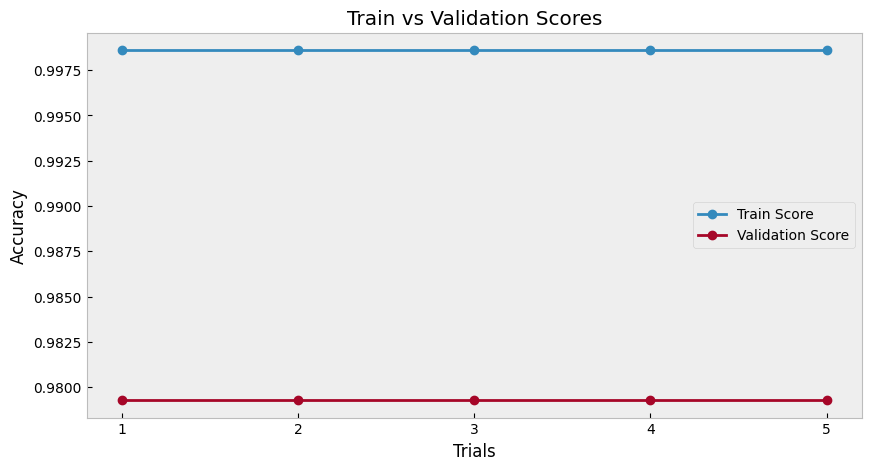

In [450]:
# Get the best trials
trials = tuner.oracle.get_best_trials(num_trials=5)  # Adjust the number of trials as needed

# Lists to collect train and validation scores
train_scores = []
val_scores = []

# Collect scores for each trial
for trial in trials: 
    train_acc = trials[0].metrics.metrics['accuracy'].get_best_value()
    val_acc = trials[0].metrics.metrics['val_accuracy'].get_best_value()
    train_scores.append(train_acc)
    val_scores.append(val_acc)

# Plotting
plt.figure(figsize=(10, 5))
epochs = range(1, len(train_scores) + 1)

plt.plot(epochs, train_scores, label='Train Score', marker='o')
plt.plot(epochs, val_scores, label='Validation Score', marker='o')

plt.title('Train vs Validation Scores')
plt.xlabel('Trials')
plt.ylabel('Accuracy')
plt.xticks(epochs)  # Show all trial numbers on the x-axis
plt.legend()
plt.grid()
plt.show()

In [452]:
# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

/Users/rishikeshdole/.pyenv/versions/3.11.1/envs/nn_llm_env/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [453]:
best_hyperparameters.values

{'num_hidden_layers': 4,
 'dropout_rate': 0.1,
 'learning_rate': 0.002331852927164919,
 'units_1': 232,
 'units_2': 200,
 'units_3': 40,
 'units_4': 72,
 'units_5': 40,
 'units_6': 104}

In [454]:
# Evaluate the best model on the test data
test_loss, test_accuracy = best_model.evaluate(X_val, y_val)
print(f"Test Accuracy: {test_accuracy:.4f}")

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - accuracy: 0.9796 - loss: 0.1665
Test Accuracy: 0.9793


In [455]:
y_pred_test = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_test, axis=1)
# Ensure predictions are diverse by checking unique predictions
pd.Series(y_pred_classes).value_counts()

875/875 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step


1    3199
7    2868
2    2823
4    2799
0    2792
3    2783
9    2748
8    2730
6    2724
5    2534
dtype: int64

In [456]:
final_submission = pd.DataFrame()
final_submission['ImageId'] = submission['ImageId']
final_submission['Label'] = np.argmax(y_pred_test, axis=1)
final_submission.to_csv('../datasets/digits_recognizer/my_submission_4.csv', sep=',', index=False)

In [ ]:
# we have gotten a validation score of 0.979, and a test submission score of 0.979 as well. I think this is a pretty good score for now. 